In [2]:
import boto3
from dotenv import load_dotenv
import os
import logging
import matplotlib.pyplot as plt
from typing import Dict, Any, Optional, List
import pandas as pd
import numpy as np
import seaborn as sns

plt.style.use("ggplot")

# Configure the logging system
logging.basicConfig(
    level=logging.INFO # We set the logging level to INFO so that INFO and above messages are logged
)

logger = logging.getLogger(__name__)

load_dotenv()

LOCAL_DIR = "data"

In [3]:
os.listdir(LOCAL_DIR)

['feature_frame.parquet']

In [6]:

bb_df = pd.read_parquet("data/feature_frame.parquet", engine="fastparquet")

In [8]:
bb_df

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880544,33826439594116,healthcarevitamins,3643254800516,3893722808452,2021-03-03 13:19:28,2021-03-03 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880545,33826439594116,healthcarevitamins,3643274788996,3883757174916,2021-03-03 13:57:35,2021-03-03 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880546,33826439594116,healthcarevitamins,3643283734660,3874925314180,2021-03-03 14:14:24,2021-03-03 00:00:00,7,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880547,33826439594116,healthcarevitamins,3643294515332,3906490826884,2021-03-03 14:30:30,2021-03-03 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392


In [9]:
bb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [10]:
bb_df[["variant_id","order_id","outcome"]].head()

,variant_id,order_id,outcome
0,33826472919172,2807985930372,0.0
1,33826472919172,2808027644036,0.0
2,33826472919172,2808099078276,0.0
3,33826472919172,2808393957508,0.0
4,33826472919172,2808429314180,0.0


In [75]:
(
    bb_df.groupby("order_id")["user_id"]
    .nunique()
    .reset_index()
)["user_id"].unique()

array([1])

In [82]:
(
    bb_df.groupby("order_id")["user_id"]
    .nunique() > 1
    ).any()

False

Con esto vemos que la relación entre "order_id" y "user_id" es 1:1

In [92]:
(
    bb_df.groupby("user_id")["order_id"]
    .nunique()
    .reset_index()
    ).max()

user_id     5029635227780
order_id               16
dtype: int64

Sin embargo, como es obvio, un usuario puede hacer más de 1 pedido. El usuario "5029635227780" fue el que más pedidos hizo (16 pedidos), aunque luego no comprara

In [134]:
user = 5029635227780
(bb_df.loc[lambda df:df["user_id"] == user].outcome == 1).sum()

2

Únicamente compró dos ítems

<Axes: xlabel='order_id'>

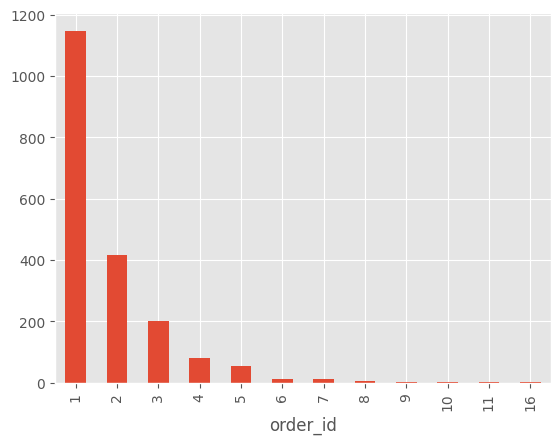

In [104]:
(
    bb_df.groupby("user_id")["order_id"]
    .nunique()
    .reset_index()
)["order_id"].value_counts().sort_index().plot(kind="bar")

In [83]:
filtered_orders = ( 
    bb_df.groupby(["order_id"])["outcome"]
    .sum()
    .reset_index()
    .loc[lambda df:df["outcome"].ge(5)]
)["order_id"]

filtered_orders

0       2807985930372
1       2808027644036
2       2808099078276
3       2808393957508
5       2808434524292
            ...      
3438    3643241300100
3441    3643254800516
3442    3643274788996
3443    3643283734660
3444    3643294515332
Name: order_id, Length: 2603, dtype: int64

In [84]:
filtered_df = bb_df.loc[lambda df:df["order_id"].isin(filtered_orders)]
filtered_df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


<Axes: xlabel='product_type'>

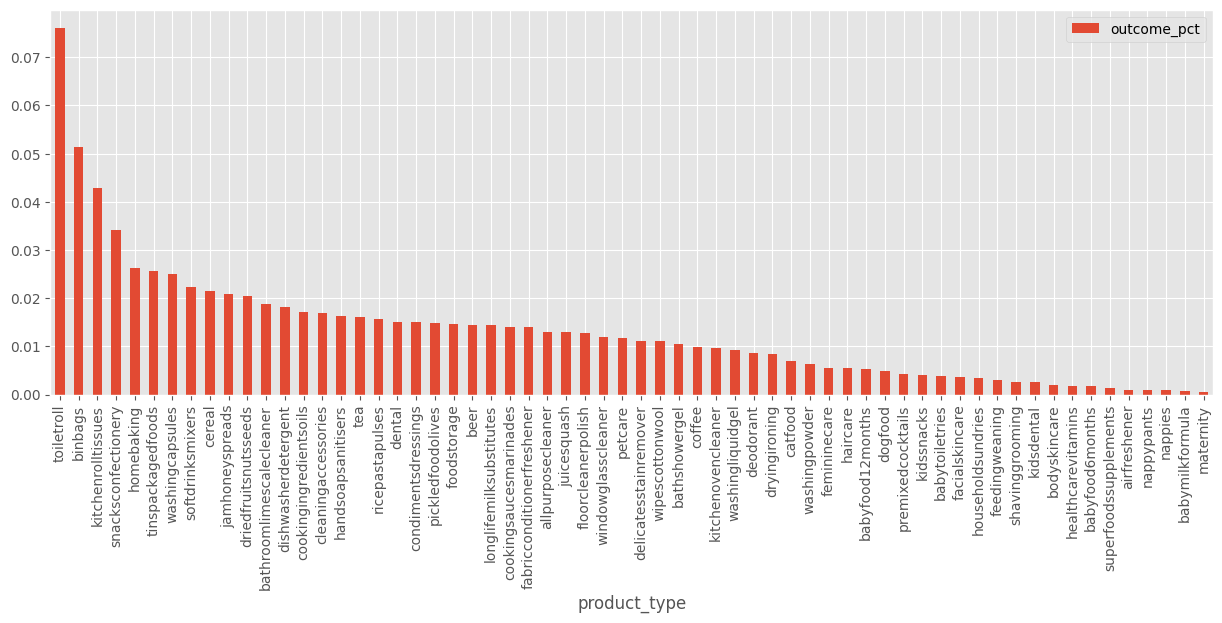

In [167]:
(
    filtered_df.groupby("product_type")["outcome"]
    .mean()
    .reset_index()
    .rename(columns = {"outcome":"outcome_pct"})
    .sort_values("outcome_pct", ascending=False)
    ).plot(kind="bar", x="product_type",figsize=(15,5))

In [174]:
info_cols

['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']

In [173]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2163953 entries, 0 to 2880547
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      float64

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
3440,33826472919172,ricepastapulses,3643252899972,5029635227780,2021-03-03 13:15:57,2021-03-03 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
5433,34465294221444,snacksconfectionery,3643252899972,5029635227780,2021-03-03 13:15:57,2021-03-03 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,23.0,13.286966,30.0,27.0,23.634873
8873,34284951273604,dishwasherdetergent,3643252899972,5029635227780,2021-03-03 13:15:57,2021-03-03 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,38.0,31.091048,30.0,32.0,25.841947
10632,34465293860996,snacksconfectionery,3643252899972,5029635227780,2021-03-03 13:15:57,2021-03-03 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,27.0,9.444575,30.0,27.0,23.634873
14078,33667302359172,cleaningaccessories,3643252899972,5029635227780,2021-03-03 13:15:57,2021-03-03 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,36.0,27.986674,30.0,35.0,29.001400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2866832,33826433859716,floorcleanerpolish,3643252899972,5029635227780,2021-03-03 13:15:57,2021-03-03 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,82.0,44.243644,30.0,38.5,31.832738
2870205,34304342982788,airfreshener,3643252899972,5029635227780,2021-03-03 13:15:57,2021-03-03 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,40.0,52.325902,30.0,39.0,35.641908
2873651,33667304784004,superfoodssupplements,3643252899972,5029635227780,2021-03-03 13:15:57,2021-03-03 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,37.0,27.032264
2877097,33667299246212,babytoiletries,3643252899972,5029635227780,2021-03-03 13:15:57,2021-03-03 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,36.0,29.372186


In [108]:

bb_df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [13]:
info_cols = ["variant_id","order_id","user_id","created_at","order_date"]
label_col = "outcome"
feature_cols = [col for col in bb_df.columns if col not in info_cols + [label_col]]

categorical_cols = ["product_type","vendor"]
binary_cols = ["ordered_before","abandoned_before","active_snoozed","set_as_regular"]
numerical_cols = [col for col in feature_cols if col not in categorical_cols + binary_cols]

In [14]:
bb_df[feature_cols]

,product_type,user_order_seq,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,vendor,global_popularity,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,ricepastapulses,3,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
1,ricepastapulses,2,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
2,ricepastapulses,4,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
3,ricepastapulses,2,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
4,ricepastapulses,3,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880544,healthcarevitamins,3,0.0,0.0,0.0,0.0,0.417186,0.114360,colief,0.000000,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880545,healthcarevitamins,4,0.0,0.0,0.0,0.0,0.417186,0.114360,colief,0.000000,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880546,healthcarevitamins,7,0.0,0.0,0.0,0.0,0.417186,0.114360,colief,0.000000,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880547,healthcarevitamins,2,0.0,0.0,0.0,0.0,0.417186,0.114360,colief,0.000000,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392


In [15]:
bb_df.product_type.unique()

array(['ricepastapulses', 'snacksconfectionery', 'dishwasherdetergent',
       'cleaningaccessories', 'fabricconditionerfreshener', 'coffee',
       'femininecare', 'bathroomlimescalecleaner', 'handsoapsanitisers',
       'tinspackagedfoods', 'toiletroll', 'kitchenrolltissues', 'binbags',
       'windowglasscleaner', 'homebaking', 'tea', 'jamhoneyspreads',
       'washingliquidgel', 'longlifemilksubstitutes', 'allpurposecleaner',
       'softdrinksmixers', 'condimentsdressings', 'babyfood6months',
       'kidssnacks', 'cookingingredientsoils', 'floorcleanerpolish',
       'cereal', 'driedfruitsnutsseeds', 'pickledfoodolives', 'catfood',
       'cookingsaucesmarinades', 'juicesquash', 'beer', 'kidsdental',
       'nappies', 'maternity', 'washingpowder', 'dental', 'haircare',
       'bathshowergel', 'kitchenovencleaner', 'wipescottonwool',
       'dogfood', 'babytoiletries', 'foodstorage', 'shavinggrooming',
       'petcare', 'deodorant', 'washingcapsules', 'bodyskincare',
       'delica

<Axes: xlabel='outcome'>

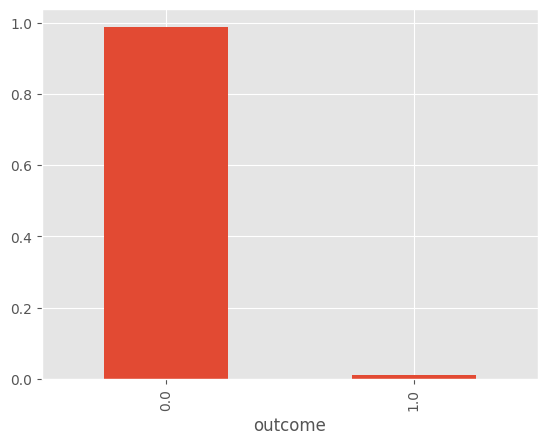

In [73]:
bb_df.outcome.value_counts(normalize=True).plot(kind="bar")